In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split

np.random.seed(11)
url = 'https://gist.githubusercontent.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6/raw/92200bc0a673d5ce2110aaad4544ed6c4010f687/pokemon.csv'
df = pd.read_csv(url, index_col='Name').drop(columns='#')
X, y = df.drop(columns='Legendary'), df['Legendary']
X_train, X_test, y_train, y_test = train_test_split(X, y)

C:\Users\My Computer\miniconda3\envs\ml\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\My Computer\miniconda3\envs\ml\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_orde

### Pipeline processor

In [2]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler
)
from category_encoders.cat_boost import CatBoostEncoder

set_config(display="diagram")

union = FeatureUnion(
    transformer_list=[
        ("pca", PCA(n_components=1)),
        ("svd", TruncatedSVD(n_components=2)),
    ]
)

# Get numeric and categorical columns
num_cols = X.select_dtypes(include="number").columns
cat_cols = list(set(X.columns) - set(num_cols))
num_pipe = Pipeline(
    [
        ("Impute", KNNImputer()),
        ("Scale", StandardScaler()),
        # ('reduce_dimensionality', union)
    ]
)
cat_pipe = Pipeline(
    [
        ('encode', CatBoostEncoder(cols=cat_cols)),
        ("Impute", KNNImputer()),
    ]
)

# Define the pipeline with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", cat_pipe, cat_cols),
        ("numeric", num_pipe, num_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=True,
)

processor = Pipeline(
    [
        ("preprocessing", preprocessor),
        # ("feature_engineering", feature_engineering),
    ]
)

In [3]:
processor.fit(X_train, y_train)
X_train_transformed = pd.DataFrame(processor.transform(X_train), columns=X_train.columns)
X_test_transformed = pd.DataFrame(processor.transform(X_test), columns=X_test.columns)

In [4]:
from xgboost import XGBClassifier
import xgboost as xgb

model = XGBClassifier()
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [5]:
all_cols = X_train_transformed.columns
explainer = shap.Explainer(model)
shap_values = explainer(X_train_transformed)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


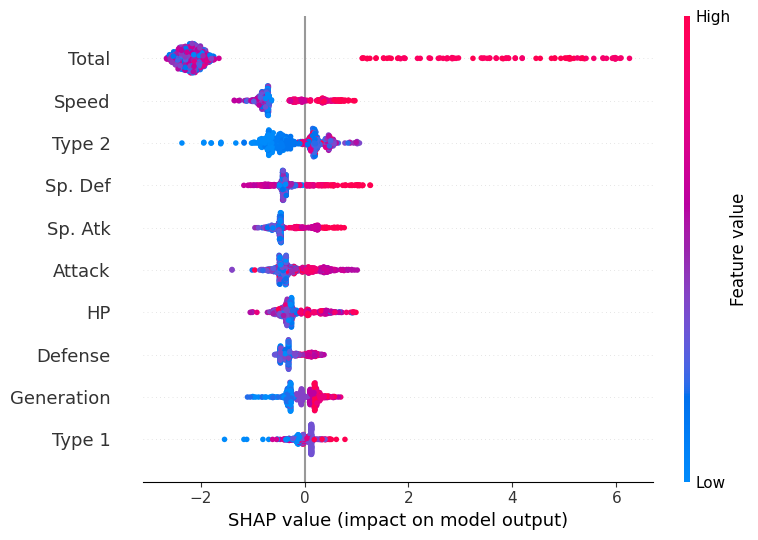

In [6]:
shap.summary_plot(shap_values, X_train_transformed)

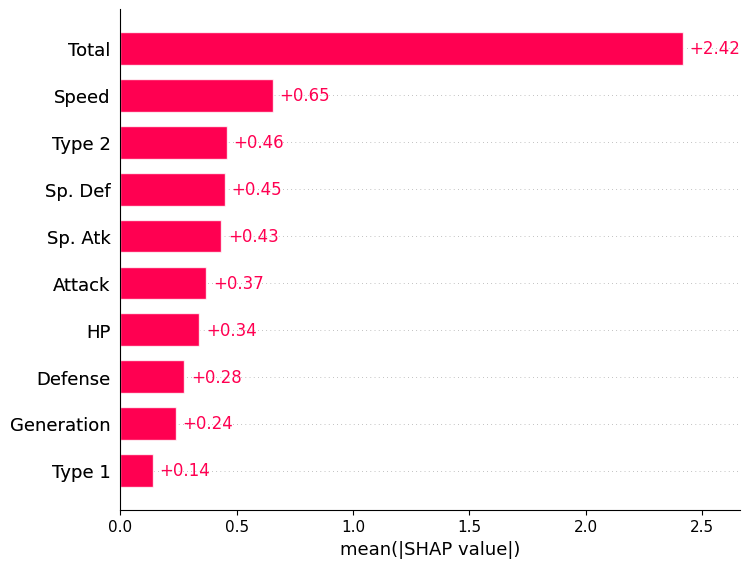

In [7]:
shap.plots.bar(shap_values)

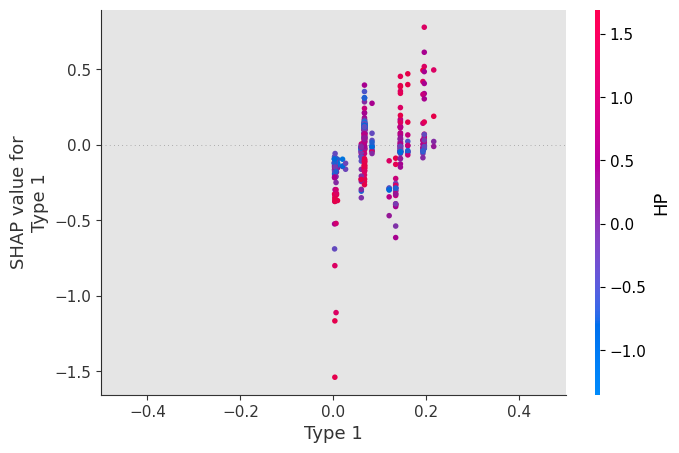

In [8]:
shap.plots.scatter(shap_values[:, "Type 1"], color=shap_values)

In [9]:
# Shap values with XGBoost core model
booster_xgb = model.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train_transformed, y_train), pred_contribs=True)
shap_values_xgb = pd.DataFrame(shap_values_xgb[:,:-1], columns=all_cols)

### Global Feature Importances with SHAP

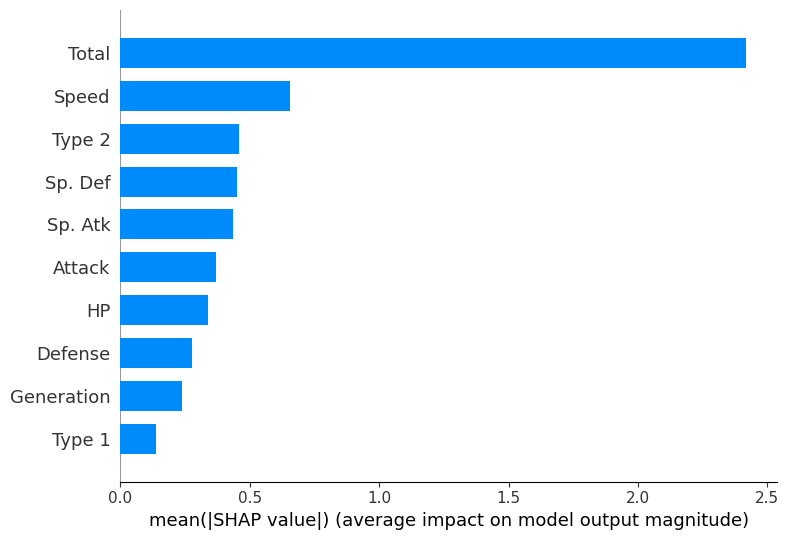

In [10]:
shap.summary_plot(
    shap_values_xgb, X_train,
    feature_names=X_train_transformed.columns, plot_type="bar"
)